# **Install Library & Mount Google Driv**

In [ ]:
!pip install timm torchsummary

from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/My Drive/Dataset_Tugas_Yohanna"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Ekstraksi Dataset ZIP**

In [ ]:
import os
import zipfile

zip_file = os.path.join(dataset_path, "archive (2).zip")
extract_folder = "/content/dataset/"

with zipfile.ZipFile(zip_file, 'r') as z:
    z.extractall(extract_folder)

print("Kelas:", os.listdir(extract_folder))

Kelas: ['Blast', 'Brownspot', 'Tungro', 'Bacterialblight']


# **Import Library & Setup Transformasi Dataset**

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import time
import cv2

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    normalize
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

dataset_root = "/content/dataset/"

# **Load Dataset, Split Train/Val/Test, dan Device**

In [ ]:
full_dataset = datasets.ImageFolder(dataset_root, transform=train_transform)

total = len(full_dataset)
train_size = int(0.7 * total)
val_size = int(0.1 * total)
test_size = total - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Kelas:", full_dataset.classes)
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Kelas: ['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']
Train: 4152, Val: 593, Test: 1187
Device: cuda


# **Definisi Training / Evaluasi / Parameter / Inference Time**

In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=3):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        print(f"Epoch {epoch+1}/{epochs}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")
    return history

def evaluate_final(model, test_loader, class_names):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs.cpu(), 1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.numpy())
    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.show()
    return y_true, y_pred

def count_parameters(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    non_trainable = total - trainable
    size_mb = total * 4 / (1024 ** 2)  # assuming float32
    return total, trainable, non_trainable, size_mb

def measure_inference_time(model, test_loader, device, warmup=50, total_images=200):
    model.eval()
    # Warm-up
    images, _ = next(iter(test_loader))
    for _ in range(warmup):
        with torch.no_grad():
            _ = model(images.to(device))

    times = []
    count = 0
    with torch.no_grad():
        for images, _ in test_loader:
            if count >= total_images:
                break
            start = time.time()
            _ = model(images.to(device))
            torch.cuda.synchronize() if device == "cuda" else None
            end = time.time()
            times.extend([end - start] * images.shape[0])
            count += images.shape[0]

    avg_time = np.mean(times[:total_images]) * 1000  # ms
    throughput = 1000 / avg_time  # images/sec
    total_time = avg_time * total_images / 1000  # seconds for total_images
    return avg_time, total_time, throughput

# **Training dan Evaluasi Model ViT, Swin, dan DeiT**


==================== TRAINING ViT ====================


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Total params: 85,801,732 | Trainable: 85,801,732 | Size: 327.31 MB
Epoch 1/3: Train Acc=0.9598, Val Acc=0.9899
Epoch 2/3: Train Acc=0.9908, Val Acc=0.9966
Epoch 3/3: Train Acc=0.9921, Val Acc=0.9646

--- FINAL EVALUATION (ViT) ---
                 precision    recall  f1-score   support

Bacterialblight       0.86      0.99      0.92       316
          Blast       0.99      0.83      0.90       298
      Brownspot       1.00      1.00      1.00       297
         Tungro       1.00      1.00      1.00       276

       accuracy                           0.96      1187
      macro avg       0.96      0.96      0.96      1187
   weighted avg       0.96      0.96      0.95      1187



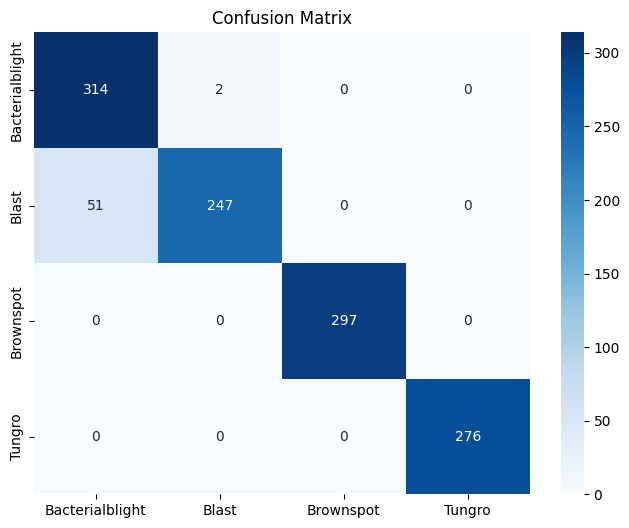

Inference time per image: 390.66 ms
Throughput: 2.56 img/sec

==================== TRAINING Swin ====================
Total params: 27,522,430 | Trainable: 27,522,430 | Size: 104.99 MB
Epoch 1/3: Train Acc=0.9557, Val Acc=1.0000
Epoch 2/3: Train Acc=0.9988, Val Acc=0.9933
Epoch 3/3: Train Acc=0.9904, Val Acc=1.0000

--- FINAL EVALUATION (Swin) ---
                 precision    recall  f1-score   support

Bacterialblight       1.00      1.00      1.00       316
          Blast       1.00      1.00      1.00       298
      Brownspot       1.00      1.00      1.00       297
         Tungro       1.00      1.00      1.00       276

       accuracy                           1.00      1187
      macro avg       1.00      1.00      1.00      1187
   weighted avg       1.00      1.00      1.00      1187



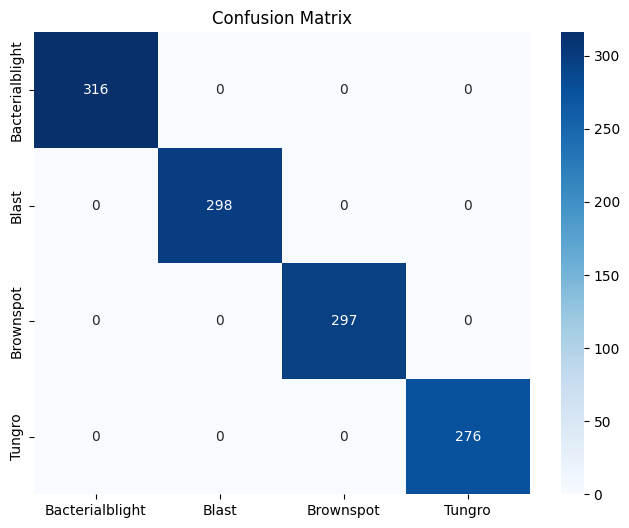

Inference time per image: 142.72 ms
Throughput: 7.01 img/sec

==================== TRAINING DeiT ====================
Total params: 5,525,188 | Trainable: 5,525,188 | Size: 21.08 MB
Epoch 1/3: Train Acc=0.9513, Val Acc=1.0000
Epoch 2/3: Train Acc=1.0000, Val Acc=1.0000
Epoch 3/3: Train Acc=1.0000, Val Acc=1.0000

--- FINAL EVALUATION (DeiT) ---
                 precision    recall  f1-score   support

Bacterialblight       1.00      1.00      1.00       316
          Blast       1.00      1.00      1.00       298
      Brownspot       1.00      1.00      1.00       297
         Tungro       1.00      1.00      1.00       276

       accuracy                           1.00      1187
      macro avg       1.00      1.00      1.00      1187
   weighted avg       1.00      1.00      1.00      1187



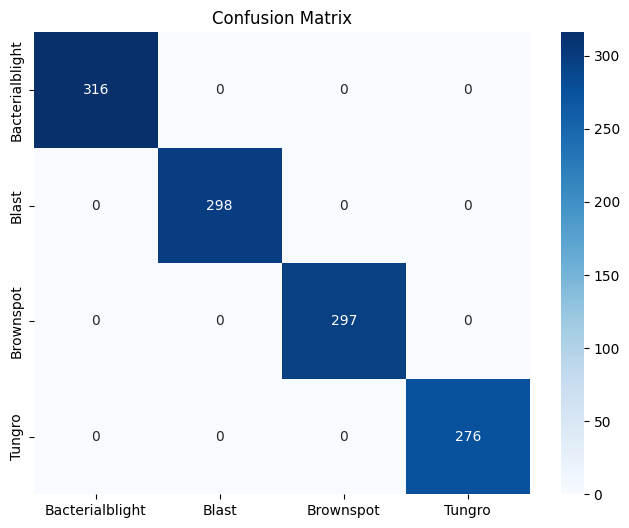

Inference time per image: 27.96 ms
Throughput: 35.77 img/sec


In [ ]:
model_names = [
    ("ViT", "vit_base_patch16_224"),
    ("Swin", "swin_tiny_patch4_window7_224"),
    ("DeiT", "deit_tiny_patch16_224")
]

results = {}

for name, arch in model_names:
    print(f"\n{'='*20} TRAINING {name} {'='*20}")
    model = timm.create_model(arch, pretrained=True, num_classes=4).to(device)

    total_p, trainable_p, non_trainable_p, size_mb = count_parameters(model)
    print(f"Total params: {total_p:,} | Trainable: {trainable_p:,} | Size: {size_mb:.2f} MB")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    history = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=3)

    print(f"\n--- FINAL EVALUATION ({name}) ---")
    y_true, y_pred = evaluate_final(model, test_loader, full_dataset.classes)

    avg_time, total_time, throughput = measure_inference_time(model, test_loader, device)
    print(f"Inference time per image: {avg_time:.2f} ms")
    print(f"Throughput: {throughput:.2f} img/sec")

    results[name] = {
        "history": history,
        "params": {"total": total_p, "trainable": trainable_p, "size_mb": size_mb},
        "inference": {"avg_ms": avg_time, "throughput": throughput}
    }

# **Visualisasi Learning Curve Model Vision Transformer**

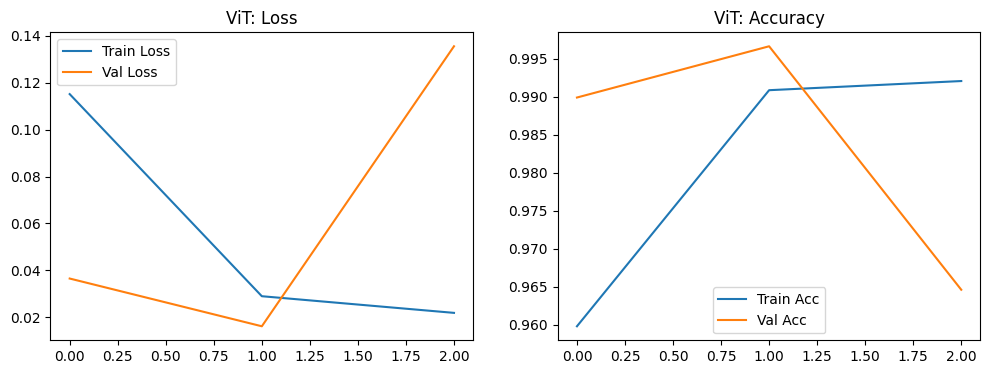

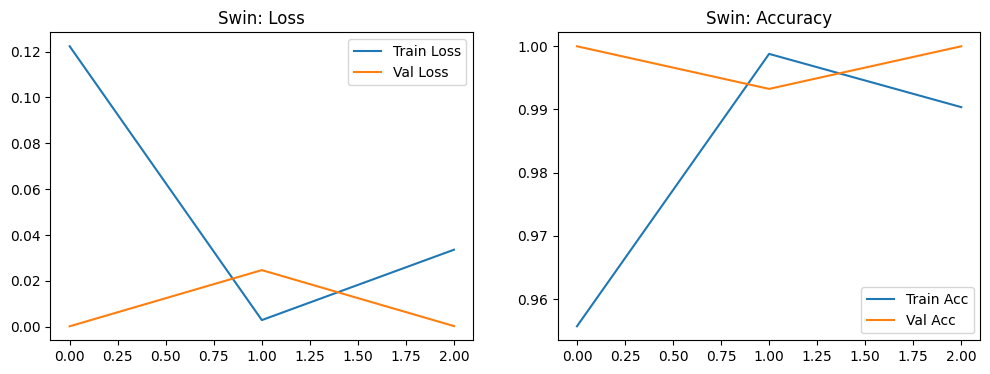

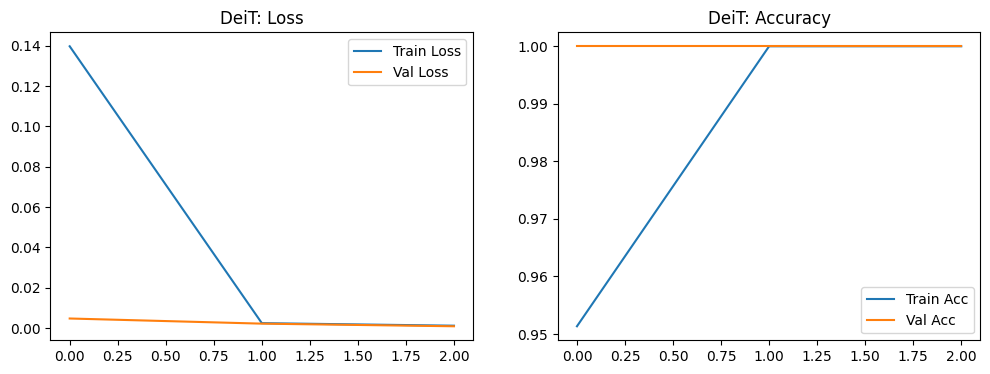

In [ ]:
for name in results:
    hist = results[name]["history"]
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(hist["train_loss"], label="Train Loss")
    plt.plot(hist["val_loss"], label="Val Loss")
    plt.title(f"{name}: Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(hist["train_acc"], label="Train Acc")
    plt.plot(hist["val_acc"], label="Val Acc")
    plt.title(f"{name}: Accuracy")
    plt.legend()
    plt.show()

# **Menampilkan Tabel Ringkasan Perbandingan Performansi Model**

In [ ]:
print("\n=== TABEL PERBANDINGAN (UNTUK LAPORAN) ===")
print(f"{'Model':<10} {'Total Params':<15} {'Size (MB)':<10} {'Infer (ms)':<12} {'Throughput':<12}")
for name, r in results.items():
    p = r["params"]
    i = r["inference"]
    print(f"{name:<10} {p['total']:<15,} {p['size_mb']:<10.2f} {i['avg_ms']:<12.2f} {i['throughput']:<12.2f}")


=== TABEL PERBANDINGAN (UNTUK LAPORAN) ===
Model      Total Params    Size (MB)  Infer (ms)   Throughput  
ViT        85,801,732      327.31     390.66       2.56        
Swin       27,522,430      104.99     142.72       7.01        
DeiT       5,525,188       21.08      27.96        35.77       
